# Time to get your hands dirty! Gamma Ray Bursts.

Let's look at the latest database of Gamma Ray Bursts.

- The database can be downloaded at [https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt](https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt)
- You can find the physical meaning of each variable at [https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html](https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html)

This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the techniques we have seen in classes so far, etc. **Be creative! You're discovering**

Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed?


In [42]:
import requests
import numpy as np
import matplotlib.pyplot as plt

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

print (names)

['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


/tmp/ipykernel_443574/3366216361.py:11: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


In [ ]:
#import corner 
#
#colonne_da_escludere = [
#    'GRB_name', 'GRB_name_Fermi', 'GBM_located',  # non number
#    'T90_error', 'fluence_error', 'pos_error'        # errors
#]
#
## valid column
#numeric_columns = []
#numeric_names = []
#
#for i, name in enumerate(names):
#    if name in colonne_da_escludere:
#        continue
#    try:
#        col = data[:, i].astype(float)
#        numeric_columns.append(col)
#        numeric_names.append(name)
#    except:
#        continue
#
## Concatena in array 2D: shape (n_samples, n_features)
#numeric_array = np.array(numeric_columns).T
#
## Rimuovi righe che contengono almeno un -999
#mask_valid = ~(numeric_array == -999)
#numeric_array_clean = numeric_array[mask_valid]
#
## Corner plot
#figure = corner.corner(numeric_array_clean, labels=numeric_names, show_titles=True) #non si vede nulla di utile e poi vengono eliminati troppi dati
#plt.show()

In [44]:
# Find column index
idx_time = np.where(names == 'T90')[0][0]
idx_fluence = np.where(names == 'fluence')[0][0]
#idx_redshift = np.where(names == 'redshift')[0][0] WE WILL NOT USE REDSHIFT BECAUSE IT'S MOST UKNOWN

# Extract columns
time = data[idx_time].astype(float)
fluence = data[idx_fluence].astype(float)

# Build dataset (one row per event, 2 columns, we dont need the corresponding errors)
new_dataset = np.column_stack((time, fluence)) 

print("Shape:", new_dataset.shape)
for i in range(10):
    print(new_dataset[i]) #check for unacceptable values


Shape: (8780, 2)
[-999. -999.]
[2.1120e+00 1.2475e-07]
[5.3760e+00 7.9799e-07]
[9.9586e+01 9.3658e-06]
[1.3568e+01 9.1754e-07]
[1.3373e+01 5.7819e-06]
[3.1806e+01 6.5088e-05]
[2.3296e+01 1.2685e-06]
[1.2416e+01 4.2913e-07]
[2.8928e+01 1.4878e-06]


In [45]:
#cleaning process
mask = np.all((new_dataset > -1) & (~np.isnan(new_dataset)) & (new_dataset != 0), axis=1)
clean_dataset = new_dataset[mask]

print("Shape:", clean_dataset.shape)
for i in range(10):
    print(clean_dataset[i])

Shape: (7521, 2)
[2.1120e+00 1.2475e-07]
[5.3760e+00 7.9799e-07]
[9.9586e+01 9.3658e-06]
[1.3568e+01 9.1754e-07]
[1.3373e+01 5.7819e-06]
[3.1806e+01 6.5088e-05]
[2.3296e+01 1.2685e-06]
[1.2416e+01 4.2913e-07]
[2.8928e+01 1.4878e-06]
[2.0928e+01 2.8390e-06]


In [46]:
from astroML import stats as astroMLstats

def bins_num (X) :

    sigmaG2 = astroMLstats.sigmaG(X) # quantile at 75 - quantile at 25
    binsize = 2.7 * sigmaG2 / (len(X)**(1/3)) #Freedman-Diaconis
    N = (max(X) - min(X))/binsize

    return int(N+2)

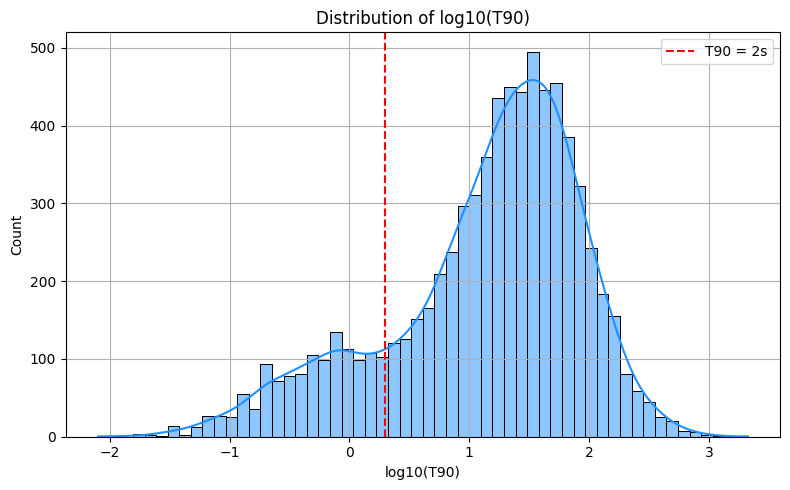

/tmp/ipykernel_443574/3465126081.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


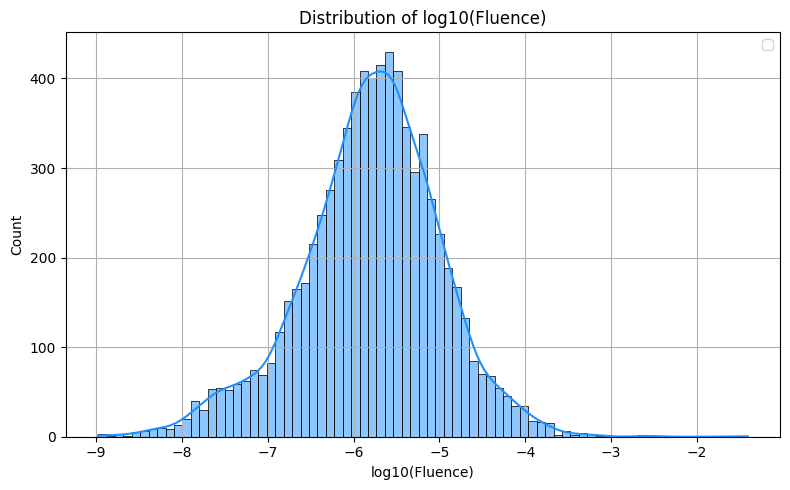

In [47]:
import seaborn as sns

logT90 = np.log10(clean_dataset[:, 0])  # the astrophysicist love everything in log10 <3
logFluence = np.log10(clean_dataset[:, 1])  

plt.figure(figsize=(8,5))   #it shows multimodality
sns.histplot(logT90, bins = bins_num(logT90), kde=True, color='dodgerblue') #seaborn has inside the KDE function
plt.xlabel("log10(T90)")
plt.ylabel("Count")
plt.title("Distribution of log10(T90)")
plt.axvline(np.log10(2), color='red', linestyle='--', label="T90 = 2s") # Discrimination time between short and long GRBs find it online
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5)) #it shows a slight multimodality
sns.histplot(logFluence, bins = bins_num(logFluence), kde=True, color='dodgerblue') 
plt.xlabel("log10(Fluence)")
plt.ylabel("Count")
plt.title("Distribution of log10(Fluence)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

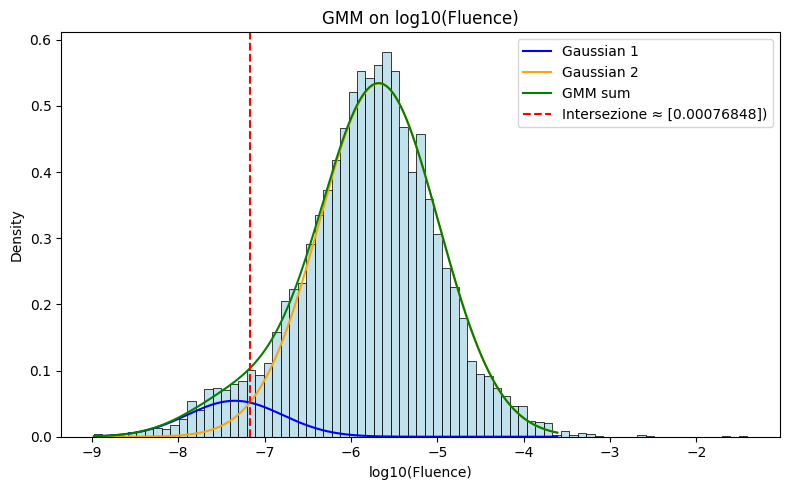

In [48]:
#Try to find the threshold in fluence 

from sklearn.mixture import GaussianMixture
from scipy.stats import norm

X = logFluence.reshape(-1, 1)

means_init = np.array([[-8], [np.median(X)]]) #starting point for one of the gaussian

gmm = GaussianMixture(n_components=2 , means_init=means_init,random_state=0).fit(X)

means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_).flatten()
weights = gmm.weights_


# Find the intersection point between the two gaussian
x = np.linspace(min(X), max(X)-2.2, 1000) #have to put max - 2.2 because in the other case the two gaussian will intersec always at max
pdf1 = weights[0] * norm.pdf(x, means[0], stds[0])
pdf2 = weights[1] * norm.pdf(x, means[1], stds[1])
diff = np.abs(pdf1 - pdf2)
min_idx = np.argmin(diff)
intersection = x[min_idx]

pdf_total = pdf1 + pdf2

plt.figure(figsize=(8,5))
sns.histplot(logFluence, bins = bins_num(logFluence), kde=False, color='lightblue', stat='density')
plt.plot(x, pdf1, color='blue', label='Gaussian 1')
plt.plot(x, pdf2, color='orange', label='Gaussian 2')
plt.plot(x, pdf_total, color='green', linestyle='-', label='GMM sum')
plt.axvline(intersection, color='red', linestyle='--', label=f'Intersezione ≈ {np.exp(intersection)})')
plt.xlabel("log10(Fluence)")
plt.ylabel("Density")
plt.title("GMM on log10(Fluence)")
plt.legend()
plt.tight_layout()
plt.show()

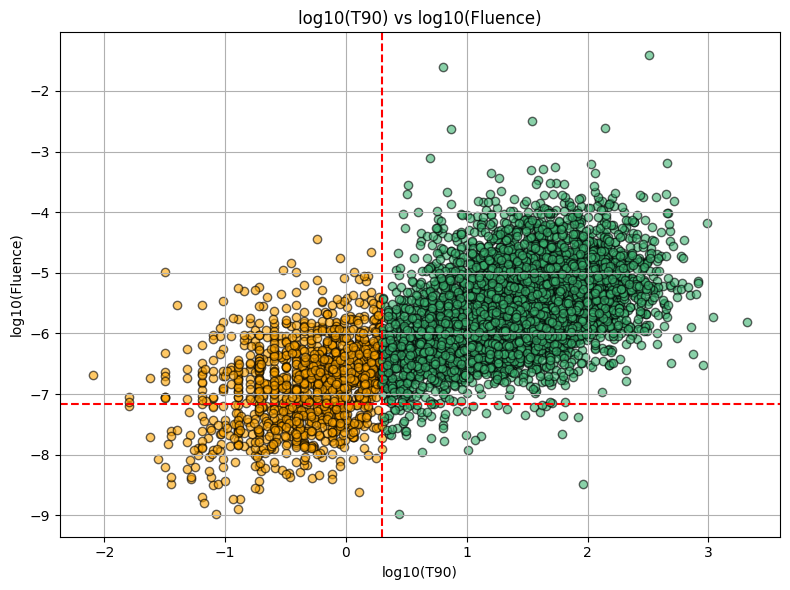

In [49]:
plt.figure(figsize=(8,6))

# Create a mask for points with T90 < 2
mask = logT90 < np.log10(2)

# Points with T90 < 2 (colored orange)
plt.scatter(logT90[mask], logFluence[mask], alpha=0.6, edgecolors='k', c='orange', label='T90 < 2s')

# Points with T90 ≥ 2 (colored mediumseagreen)
plt.scatter(logT90[~mask], logFluence[~mask], alpha=0.6, edgecolors='k', c='mediumseagreen', label='T90 ≥ 2s')

plt.xlabel("log10(T90)")
plt.ylabel("log10(Fluence)")
plt.title("log10(T90) vs log10(Fluence)")
plt.grid(True)
plt.axhline(intersection, color='red', linestyle='--', label=f'Intersection ≈ {np.exp(intersection)})')
plt.axvline(np.log10(2), color='red', linestyle='--', label="T90 = 2s")
plt.tight_layout()
plt.show()



In [50]:
# KMeans try to "fit" the chosen number of cluster to the data

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

X = np.column_stack((logT90, logFluence))

scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
best_score = 0

for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=0).fit(X_scaled)
    
    # Silhouette score measures how well-separated and cohesive the clusters are:
    # values close to 1 indicate well-defined clusters, near 0 indicate overlapping,
    # and negative values suggest misclassified points.
    
    s = silhouette_score(X_scaled, km.labels_)

    if s > best_score:
      best_score = s
      best_k = k
    
print("\nBest k:", best_k)
print("Best silhouette score:", best_score)
    


Best k: 2
Best silhouette score: 0.5154129427818412


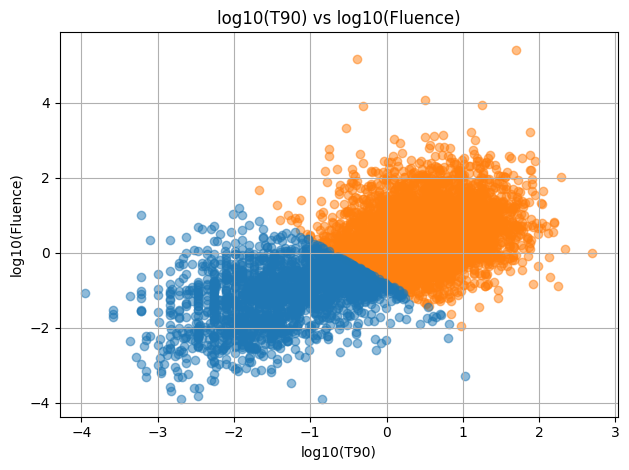

In [51]:

clf = KMeans(n_clusters= best_k, n_init= best_k+10) 
clf.fit(X_scaled)
labels = clf.predict(X_scaled) #labels for each of the points

# plot the data color-coded by cluster id
colors = ['C1', 'C0']
plt.scatter(X_scaled[labels==0,0], X_scaled[labels==0,1], color=colors[0],alpha=0.5)
plt.scatter(X_scaled[labels==1,0], X_scaled[labels==1,1], color=colors[1],alpha=0.5)

plt.xlabel("log10(T90)")
plt.ylabel("log10(Fluence)")
plt.title("log10(T90) vs log10(Fluence)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
# Compute the Mean-shift clustering, which is a non-parametric clustering algorithm
# it does not require the number of clusters to be specified in advance, because it finds the best number of clusters based on the data

from sklearn.cluster import MeanShift
from tqdm.notebook import tqdm

In [ ]:
# here the problem is that the bandwidth is not known
# the bandwidth is a parameter that defines the size of the region around each point
# in which the algorithm will search for points to form a cluster

# bandwidth range
bandwidth_values = np.linspace(0.1, 0.5, 25)
best_score = 0

for i in tqdm(bandwidth_values): # GridSearch isn't compatible, I emulate it 
    ms = MeanShift(bandwidth=i/10, bin_seeding=True, cluster_all=False)
    ms.fit(X_scaled)
    s = silhouette_score(X_scaled, ms.labels_)

    print(s, "\n")

    if s > best_score:
        best_score = s
        best_bandwidth = i
    
print("\nBest bandwidth:", best_bandwidth)
print("Best silhouette score:", best_score)

    

  0%|          | 0/50 [00:00<?, ?it/s]

0.18893437868290966 

0.23415794675192236 

0.25784626535672855 

0.26753913758745895 

0.2691468993718109 

0.2722902263939204 

0.25813247716312826 

0.26105390915697196 

0.25255247067606723 

0.24412788956189402 

0.24676655270478015 

0.23381467628381242 

0.22468854622709195 

0.2273914708914274 

0.2251115785051 

0.21132986951303365 

0.21660258674530056 

0.20961923805991148 

0.1898869262438161 

0.21042339725200437 

0.20593827173083262 

0.2033853296591858 

0.1893572573549691 

0.19345192351572754 

0.18273582676236236 

0.1874625931097581 

0.17370931130286096 

0.18717585924233135 

0.1700455921924151 

0.17321733037052994 

0.15309738531281897 

0.16899934151661822 

0.12252319675159176 

0.1262268532634933 

0.12339205780197916 

0.09313866397450181 

0.11338423310427444 

0.11048615947141917 

0.08237234838483146 

0.05754340396506821 

0.025133566054956338 

0.012987523586080204 

-0.016956157341284403 

-0.01269229227692147 

-0.03903022314876172 

-0.06007353602745

number of estimated clusters: 63


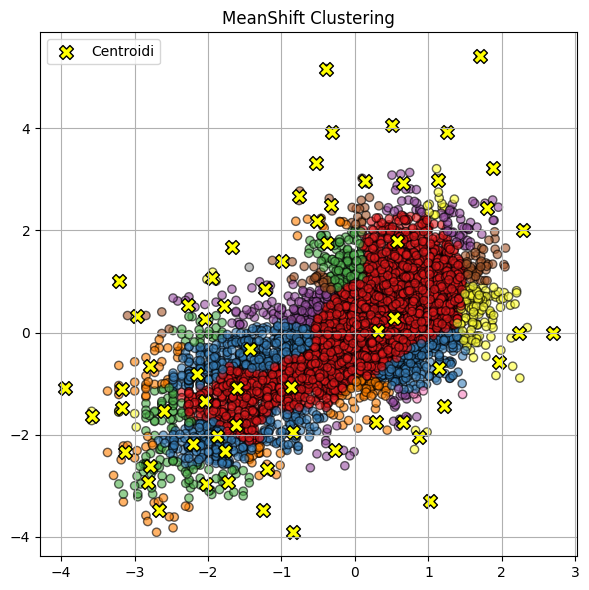

In [54]:

ms = MeanShift(bandwidth= best_bandwidth , bin_seeding=True, cluster_all=True)
# if i put cluster_all = False, it will  assign a label (-1) to the points that are not in any cluster
ms.fit(X_scaled)

labels_ms = ms.labels_
centers_ms = ms.cluster_centers_

# Number of estimated cluster 
labels_unique = np.unique(labels_ms)
n_clusters = len(labels_unique[labels_unique >= 0]) #if ther's point with labebl -1, they are not counted
print("number of estimated clusters:", n_clusters)

# Plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()

# Scatter of the point  with different color for each cluster
scatter = ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_ms, cmap='Set1', alpha=0.6, edgecolors='k')

# Scatter of the centroids
ax.scatter(centers_ms[:, 0], centers_ms[:, 1], s=100, c='yellow', edgecolors='black', marker='X', label='Centroidi')

ax.set_title('MeanShift Clustering')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


we can see an important thing about the outliars here:
- In KMeans algorithm, we are searching for a number of cluster chosen by us, the ouliars are irrelevant, it's the main set of data that determine everything
- In MeanShift if a point is far away from the other point will became a cluster it self, that's because the algorithm find the mean of a cluster and connect all the point that are under the correct lenght